In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

#pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')
from IPython.display import IFrame

import os
import pickle
import requests

from shapely.geometry import Point
import geocoder
import geopandas as gpd
from fiona.crs import from_epsg


### Merging geocoding results dfs

In [2]:
A1_geo_df = pd.read_csv('../Data/A1_geocoded_df.csv')

In [7]:
numbers_df = range(0,282,1)
sorted_list_df  = ['GeocodedDF_' + str(number) + '.csv' for number in numbers_df]

list_dfs = []
for df in sorted_list_df:
    csv_df = pd.read_csv('./GeoResults/' + df, index_col='date_time')
    list_dfs.append(csv_df)
A1_geo_df = pd.concat(list_dfs)
#A1_geo_df.to_csv('A1_geocoded_df.csv')

FileNotFoundError: File b'./GeoResults/GeocodedDF_0.csv' does not exist

### Geoplotting

In [3]:
#A1_geo_df = pd.read_csv('A1_geocoded_df.csv', index_col='date_time')
A1_geo_df['geometry'] = [Point(xy) for xy in zip(A1_geo_df['lng'], A1_geo_df['lat'])]
A1_geo_df = gpd.GeoDataFrame(A1_geo_df, geometry='geometry')
A1_geo_df.head()

,date_time,date,time,address,descr,urgency,lat,lng,geometry
0,2017-05-15 18:49:48,2017-05-15 00:00:00,1900-01-01 18:49:48,"Amsterdam, Van Hogendorpplein 20-28, 1051AX",Ambulance met hoge spoed: 13102 Rit 56158 Ams...,Ambulance met hoge spoed,52.38497,4.87637,POINT (4.87637 52.38497)
1,2017-05-15 18:37:55,2017-05-15 00:00:00,1900-01-01 18:37:55,"Amsterdam, Marnixstraat 1-9, 1017PJ",Ambulance met hoge spoed: 13116 Rit 56156 Ams...,Ambulance met hoge spoed,52.38366,4.88260,POINT (4.8826 52.38366)
2,2017-05-15 18:31:50,2017-05-15 00:00:00,1900-01-01 18:31:50,"Amsterdam, Walmolen 100-108, 1035BP",Ambulance met hoge spoed: 13159 Rit 56155 Ams...,Ambulance met hoge spoed,52.41876,4.88855,POINT (4.88855 52.41876)
3,2017-05-15 18:27:52,2017-05-15 00:00:00,1900-01-01 18:27:52,"Diemen, Muiderstraatweg 20-28, 1111PS",Ambulance met hoge spoed: 13110 Rit 56154 Diemen,Ambulance met hoge spoed,52.33779,4.96479,POINT (4.96479 52.33779000000001)
4,2017-05-15 18:21:49,2017-05-15 00:00:00,1900-01-01 18:21:49,"Amsterdam, Ruijterkade",Ambulance met hoge spoed: 13104 Rit 56150 De ...,Ambulance met hoge spoed,52.37754,4.90832,POINT (4.90832 52.37754)


In [4]:
loc_gdf = A1_geo_df['geometry']
loc_gdf.crs = from_epsg(code='4326')

In [5]:
# shape file of amsterdam-amstelland region
watergrens = gpd.read_file('../Data/Veiligheidsregios-watergrenzen-exact-actueel-shp/Veiligheidsregios-watergrenzen-exact-actueel.shp')

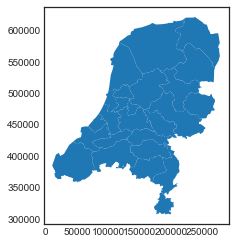

In [6]:
watergrens.plot()

In [7]:
# ratio of original crs
bounds = watergrens[watergrens['naam']=='Amsterdam-Amstelland'].bounds
ratio = (bounds['maxy']-bounds['miny'])/(bounds['maxx']-bounds['minx'])

In [8]:
# convert crs
watergrens2 = watergrens.to_crs(epsg='4326')

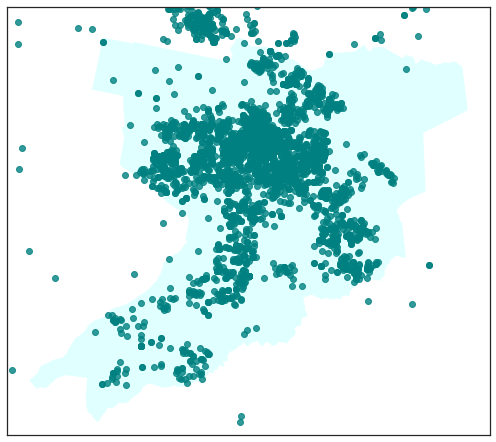

In [9]:
# plot first 4000 calls
dim = 7
fig,ax = plt.subplots(figsize=(dim, ratio*dim))
watergrens2[watergrens2['naam']=='Amsterdam-Amstelland'].plot(ax=ax, color='lightcyan')
loc_gdf[0:4000].plot(ax = ax, marker='o', color='teal', alpha=0.8)
ax.set_xlim(4.65, 5.10)
ax.set_ylim(52.20, 52.45)
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_yticklabels([])
plt.tight_layout()
#plt.savefig('urgent_calls4000_plot.png', dpi=300)


#### Plot using gmplot

In [10]:
import gmplot

latitudes = A1_geo_df.iloc[:4000, 5]
longitudes = A1_geo_df.iloc[:4000, 6]

In [11]:
gmap = gmplot.GoogleMapPlotter(52.3469157,4.8639372,11)
gmap.scatter(latitudes, longitudes, 'black', size=15, marker=False)
gmap.draw("urgent_calls4000_google_plot.html")

TypeError: can't multiply sequence by non-int of type 'float'

In [ ]:
IFrame('urgent_calls4000_google_plot.html', width=600, height=600)

In [12]:
# remove lat longs that are outside amsterdam amstelland
bounds2 = watergrens2[watergrens2['naam']=='Amsterdam-Amstelland'].bounds

A1_clean_geo_df = A1_geo_df[(A1_geo_df['lat'] >= float(bounds2['miny'])) &
                            (A1_geo_df['lat'] <= float(bounds2['maxy'])) &
                            (A1_geo_df['lng'] >= float(bounds2['minx'])) &
                            (A1_geo_df['lng'] <= float(bounds2['maxx']))]

loc_clean_gdf = A1_clean_geo_df['geometry']
loc_clean_gdf.crs = from_epsg(code='4326')

#### Plot using staticmap

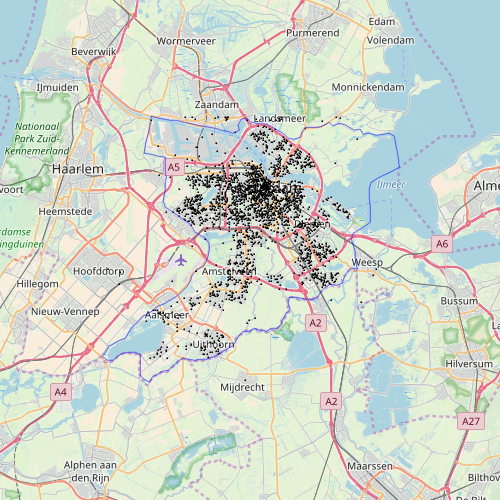

In [13]:
from staticmap import StaticMap, CircleMarker, Polygon

m = StaticMap(500, 500, url_template='http://a.tile.osm.org/{z}/{x}/{y}.png')

coordinates_polygon = list(watergrens2.loc[14,'geometry'].exterior.coords)
polygon = Polygon(coordinates_polygon, outline_color='blue', fill_color=None)
m.add_polygon(polygon)

for point in A1_clean_geo_df['geometry'][0:4000]:
    marker = CircleMarker((point.x,point.y), 'black', 1)
    m.add_marker(marker)

image = m.render(zoom=10)
#image.save('A1_sample_staticmap.png')
image

### Clustering

There are 7 ambulance stations -> cluster into 7 clusters

In [14]:
# cluster using kmeans
from sklearn.cluster import KMeans

X_Kmeans = A1_clean_geo_df.iloc[1:10000,6:8]
cluster_labels_Kmeans = KMeans(n_clusters=7, random_state=5).fit_predict(X_Kmeans)

In [20]:
def plot_cluster(data, cluster_labels, dim=7):
    plt.figure(figsize=(dim, ratio*dim))
    plt.scatter(data['lng'], data['lat'], c=cluster_labels, cmap='tab20', s=10, alpha=0.7)

In [21]:
def plot_clusterpoints_region(data, cluster_labels, dim=7):
    fig,ax = plt.subplots(figsize=(dim, ratio*dim))
    watergrens2[watergrens2['naam']=='Amsterdam-Amstelland'].plot(ax=ax, alpha=0)
    ax.scatter(data['lng'], data['lat'], c=cluster_labels, cmap='tab20', s=10, alpha=0.7)
    ax.set_xlim(4.65, 5.10)
    ax.set_ylim(52.20, 52.45)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    plt.tight_layout()


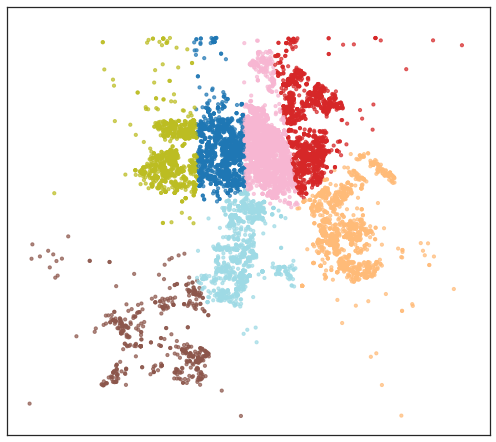

In [49]:
plot_clusterpoints_region(X_Kmeans, cluster_labels_Kmeans)

In [15]:
# clustering using agglomorative clustering
from sklearn.cluster import AgglomerativeClustering

In [28]:
X = A1_clean_geo_df.sample(30000, random_state=5).iloc[:,6:8]

cluster_labels_dict = {}
for linkage_type in {'ward', 'complete', 'average'}:
    cluster_labels_dict[linkage_type] = AgglomerativeClustering(n_clusters=7, linkage=linkage_type).fit_predict(X)

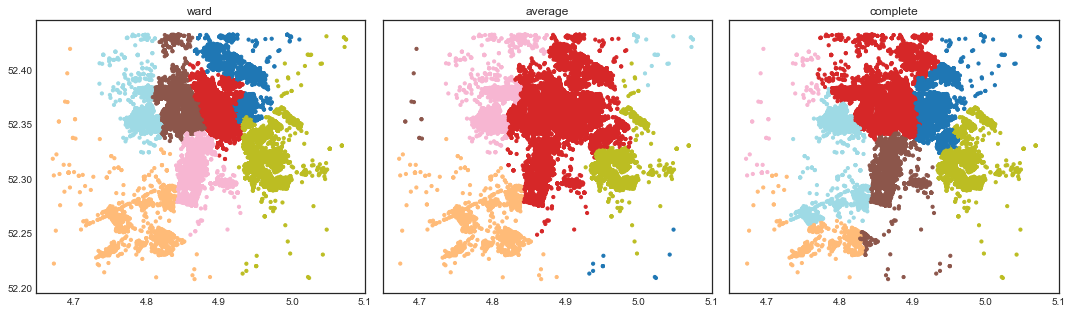

In [29]:
dim = 5

fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(3*dim, ratio*dim))
i = 0
for linkage_type, value in cluster_labels_dict.items():
    watergrens2[watergrens2['naam']=='Amsterdam-Amstelland'].plot(ax=ax[i], alpha=0)
    ax[i].scatter(X['lng'], X['lat'], c=cluster_labels_dict[linkage_type], cmap='tab20', s=10)
    ax[i].set_title(linkage_type)
    plt.tight_layout()
    i +=1

Ward linkage gives most realistic results based on neighborhoods in Amsterdam-Amstelland

Agglomorative clustering does not work on > 50,000 examples -> cluster based on 30,0000  
n_clusters = 7 because that's the number of ambulance stations there are in Amsterdam-Amstelland

In [30]:
X_AC = A1_clean_geo_df.sample(10000, random_state=5).iloc[:,6:8]
AC = AgglomerativeClustering(n_clusters=7, linkage='ward').fit(X_AC)
cluster_labels_AC = AC.labels_

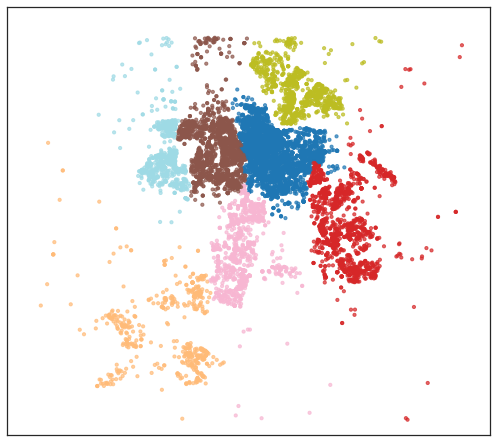

In [31]:
plot_clusterpoints_region(X_AC, cluster_labels_AC)

Try minibatchkmeans

In [23]:
from sklearn.cluster import MiniBatchKMeans

In [25]:
A1_clean_geo_df.head()

,date_time,date,time,address,descr,urgency,lat,lng,geometry
0,2017-05-15 18:49:48,2017-05-15 00:00:00,1900-01-01 18:49:48,"Amsterdam, Van Hogendorpplein 20-28, 1051AX",Ambulance met hoge spoed: 13102 Rit 56158 Ams...,Ambulance met hoge spoed,52.38497,4.87637,POINT (4.87637 52.38497)
1,2017-05-15 18:37:55,2017-05-15 00:00:00,1900-01-01 18:37:55,"Amsterdam, Marnixstraat 1-9, 1017PJ",Ambulance met hoge spoed: 13116 Rit 56156 Ams...,Ambulance met hoge spoed,52.38366,4.88260,POINT (4.8826 52.38366)
2,2017-05-15 18:31:50,2017-05-15 00:00:00,1900-01-01 18:31:50,"Amsterdam, Walmolen 100-108, 1035BP",Ambulance met hoge spoed: 13159 Rit 56155 Ams...,Ambulance met hoge spoed,52.41876,4.88855,POINT (4.88855 52.41876)
3,2017-05-15 18:27:52,2017-05-15 00:00:00,1900-01-01 18:27:52,"Diemen, Muiderstraatweg 20-28, 1111PS",Ambulance met hoge spoed: 13110 Rit 56154 Diemen,Ambulance met hoge spoed,52.33779,4.96479,POINT (4.96479 52.33779000000001)
4,2017-05-15 18:21:49,2017-05-15 00:00:00,1900-01-01 18:21:49,"Amsterdam, Ruijterkade",Ambulance met hoge spoed: 13104 Rit 56150 De ...,Ambulance met hoge spoed,52.37754,4.90832,POINT (4.90832 52.37754)


In [80]:
X_mini = A1_clean_geo_df.iloc[:,6:8]
mb = MiniBatchKMeans(n_clusters=7, random_state=5).fit(X_mini)
cluster_labels_MiniK = mb.predict(X_mini)
X_mini['cluster_labels'] = cluster_labels_MiniK
centroids = mb.cluster_centers_

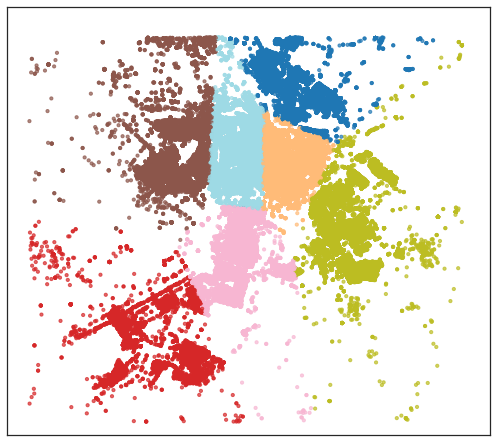

In [81]:
plot_clusterpoints_region(X_mini, cluster_labels_MiniK)

Proceed with agglomorative clustering

In [33]:
AC_df = A1_clean_geo_df.sample(10000, random_state=5)
AC_df['cluster_labels'] = cluster_labels_AC
pickle.dump(AC_df, open('AC_df_results.p', 'wb'))

In [34]:
colors = ['red', 'yellow', 'blue', 'green', 'indigo', 'darkorange', 'magenta']

gmap = gmplot.GoogleMapPlotter(52.3469157,4.8639372,11)

i = 0
for label in AC_df['cluster_labels'].unique():
    lats = AC_df['lat'][AC_df['cluster_labels']==label]
    longs = AC_df['lng'][AC_df['cluster_labels']==label]
    gmap.scatter(lats, longs, colors[i], size=15, marker=False)
    i += 1
    
gmap.draw("AC_cluster_urgent.html")

In [35]:
IFrame('AC_cluster_urgent.html', width=400, height=400)

Locations of current ambulance stations:

In [36]:
ambulancestands_df = pd.read_pickle('../Data/ambulancestands_geo.p')
ambulancestands_locs = ambulancestands_df['latlng'].apply(lambda x: tuple(x[::-1]))

Extract center of cluster using geopandas:

In [48]:
centers_list = []
for label in AC_df['cluster_labels'].unique():
    geo_series = AC_df[AC_df['cluster_labels']==label]['geometry']
    center = geo_series.unary_union.centroid
    centers_list.append((center.x, center.y))

Plot clusters + current ambulance stations + cluster centers:

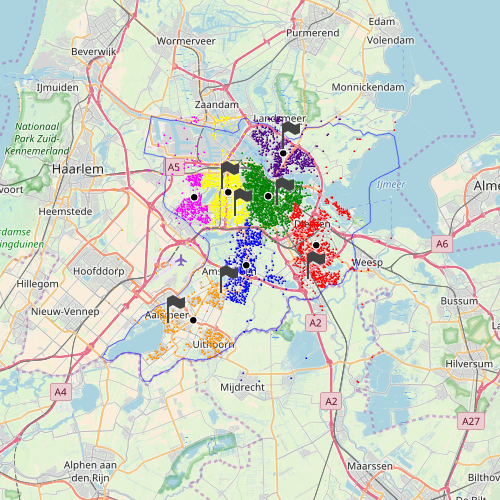

In [38]:
from staticmap import IconMarker

colors = ['red', 'yellow', 'blue', 'green', 'indigo', 'darkorange', 'magenta']

m = StaticMap(500, 500, url_template='http://a.tile.osm.org/{z}/{x}/{y}.png')

coordinates_polygon = list(watergrens2.loc[14,'geometry'].exterior.coords)
polygon = Polygon(coordinates_polygon, outline_color='blue', fill_color=None)
m.add_polygon(polygon)

# plot clusters
i=0
for label in AC_df['cluster_labels'].unique():
    df = AC_df[AC_df['cluster_labels']==label]
    for point in df[['lng','lat']].apply(tuple, axis=1):
        marker = CircleMarker(point, colors[i], 1)
        m.add_marker(marker)
    i+=1

# plot current ambulance stations
for station in ambulancestands_locs:
    icon_flag = IconMarker(station, 'icon-flag.png', 12, 32)
    m.add_marker(icon_flag)
    
# plot cluster centroids
for center in centers_list:
    marker_outline = CircleMarker(center, 'white', 8)
    marker = CircleMarker(center, 'black', 6)
    m.add_marker(marker_outline)
    m.add_marker(marker)

image = m.render(zoom=10)
image.save('AC_result_staticmap.png')
image

**To do:**
- Plot neighbourhoods shapes
- Remove calls that fall outside geometrical boundary: geometry_within + buffer
- Extract clustering boundaries
- Constraint clustering: get latest constraint_kmeans.py from bitbucket
- Determine best clustering method based on shortest path analysis using pandana


Try 8 clusters

In [86]:
X_mini = A1_clean_geo_df.iloc[:,6:8]
mb = MiniBatchKMeans(n_clusters=8, random_state=5).fit(X_mini)
cluster_labels_MiniK = mb.predict(X_mini)
X_mini['cluster_labels'] = cluster_labels_MiniK
centroids = mb.cluster_centers_

In [87]:
centers_list = []
row = 0
while row <= len(centroids)-1:
    center_x = mb.cluster_centers_[row][1]
    center_y = mb.cluster_centers_[row][0]
    centers_list.append((center_x, center_y))
    row +=1

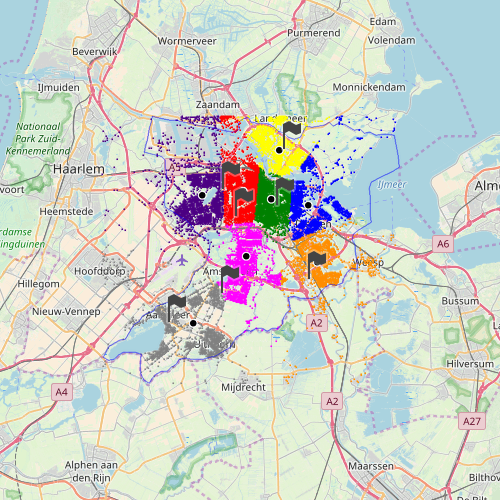

In [91]:
from staticmap import IconMarker

colors = ['red', 'yellow', 'blue', 'green', 'indigo', 'darkorange', 'magenta','grey']

m = StaticMap(500, 500, url_template='http://a.tile.osm.org/{z}/{x}/{y}.png')

coordinates_polygon = list(watergrens2.loc[14,'geometry'].exterior.coords)
polygon = Polygon(coordinates_polygon, outline_color='blue', fill_color=None)
m.add_polygon(polygon)

# plot clusters
i=0
for label in X_mini['cluster_labels'].unique():
    df = X_mini[X_mini['cluster_labels']==label]
    for point in df[['lng','lat']].apply(tuple, axis=1):
        marker = CircleMarker(point, colors[i], 1)
        m.add_marker(marker)
    i+=1

# plot current ambulance stations
for station in ambulancestands_locs:
    icon_flag = IconMarker(station, 'icon-flag.png', 12, 32)
    m.add_marker(icon_flag)
    
# plot cluster centroids
for center in centers_list:
    marker_outline = CircleMarker(center, 'white', 8)
    marker = CircleMarker(center, 'black', 6)
    m.add_marker(marker_outline)
    m.add_marker(marker)

image = m.render(zoom=10)
image.save('MiniBatchKmeans_result_staticmap_8stations.png')
image